### MLBD

In [1]:
# !pip install --upgrade pyspark
# !pip install --upgrade matplotlib==3.6.1

In [2]:
# !pip install sklearn numpy pandas datasist
# !pip install pyspark spark spark-nlp
# !pip install geopandas shapely
# !pip install matplotlib mpl_toolkits
# !pip install plotly kaleido
# !pip install -U kaleido
# !pip install folium
# !pip install geopy
# !pip install branca
# !pip install altair
# !pip install pycountry

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles, SparkContext, SparkConf
from functools import reduce  # For Python 3.x
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Row
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import glob
import folium
import warnings
import geopy
import branca
import altair as alt
import pycountry
import datetime

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
conf_spark = SparkConf().set("spark.driver.host", "127.0.0.1")
sc = SparkContext(conf=conf_spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/01 19:10:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark = SparkSession.builder.appName('airscholar').getOrCreate()

In [4]:
# spark._sc.stop()

In [51]:
class MLBD:
    def extract_computation_dates(self):
        """
        This functions extracts all the dates on the files in dataset directory
            Returns:
            array: list of dates in the dataset folder
        """
        #read all the datasets
        json_dates = glob.glob("datasets/*.json")
        #sort them by the name
        json_dates.sort()
        #extract dates from the list
        json_dates = [json.replace('datasets/data.24h-', '').replace('.json', '') for json in json_dates]
        
        return json_dates

    def read_all_jsons(self):
        """
        This functions reads all the datasets downloaded into datasets folder
            Returns:
                base_data_df: list of dataframes for each day
        """
        # add all files in datasets directory to spark
        spark.sparkContext.addFile('datasets', recursive=True)
        #get all the data in the dataset directory as json
        jsons = glob.glob("datasets/*.json")
        #order them by name
        jsons.sort()
        
        base_data_df = []

        for i in range(0, len(jsons)):
            json_obj = jsons[i]
            #add the file to spark for processing
            spark.sparkContext.addFile(json_obj)
            # print(json_obj)
            #read the json into dataframe
            t_df = spark.read.json("file://"+SparkFiles.get(json_obj))
            #sort by timestamp
            t_df = t_df.sort(t_df.timestamp)
            #add the dataframe to the array
            base_data_df.append(t_df)
        return base_data_df

    def extractSensorValues(self, base_data_df):
        """
        This function extracts the data in the sensor field
            Arguments:
                base_data_df: dataframe
            Returns:
                sensor_df: dataframe
        """
        #extract sensor data values, id and types
        sensor_df = base_data_df\
        .withColumn('sensorId', base_data_df.sensor.getField('id').cast(StringType()))\
        .withColumn('sdvID', base_data_df.sensordatavalues.getField('id').cast(StringType()))\
        .withColumn('sdvValue', base_data_df.sensordatavalues.getField('value'))\
        .withColumn('sdvValue_type', base_data_df.sensordatavalues.getField('value_type'))
        #drop unused columns after extraction
        sensor_df = sensor_df.drop('sampling_rate', 'sensor', 'sensordatavalues')
        
        #filter only records with P1 and P2
        sensor_df = sensor_df.filter(array_contains(sensor_df['sdvValue_type'], 'P1') & array_contains(sensor_df['sdvValue_type'], 'P2'))
        #extract the position of P1 and P2 in the array
        sensor_df = sensor_df.withColumn('P1_Pos', array_position(sensor_df.sdvValue_type, "P1")-1).withColumn('P2_Pos', array_position(sensor_df.sdvValue_type, "P2")-1)
        #extract the value of the P1 and P2 in the array using the array position. Then convert to integer datatype from string
        sensor_df = sensor_df.withColumn('P1', sensor_df['sdvValue'][sensor_df.P1_Pos.cast(IntegerType())])\
        .withColumn('P2', sensor_df['sdvValue'][sensor_df.P2_Pos.cast(IntegerType())])
        #extract and convert P1 and P2 data to Float
        sensor_df.withColumn('P1', sensor_df.P1.cast(FloatType())).withColumn('P2', sensor_df.P2.cast(FloatType()))
        
        #drop the unused columns
        sensor_df = sensor_df.drop('sdvID','sdvValue_type', 'sdvValue', 'P1_Pos', 'P2_Pos')
        
        return sensor_df
    
    def extractLocationInfo(self, sensor_df):
        """
        This function extracts the data in the location field
            Arguments: 
                sensor_df: sensor dataframe with unprocessed location information
            Returns:
                location_df: location dataframe with processed location
        """
        #extract the country information with latitude and longitude
        location_df = sensor_df.withColumn('country', sensor_df.location.getField('country'))
        location_df = location_df.withColumn('latitude', location_df.location.getField('latitude').cast(FloatType()))\
        .withColumn('longitude', location_df.location.getField('longitude').cast(FloatType())).drop('location')
        
        #UK is not a valid ISO2 code, replace with GB
        location_df = location_df.withColumn('country', regexp_replace('country', 'UK', 'GB'))
        
        return location_df
    
    def clean_data(self, base_data_df):
        """
        This function extracts the values in the dataset field
            Arguments:
                base_data_df: raw data with unprocessed sensor and location data
            Returns:
                clean_data: cleaned dataframe
        """
        #convert timestamp datatype from string to timestamp type
        base_data_df = base_data_df.withColumn('timestamp', base_data_df.timestamp.cast(TimestampType()))
        
        #extract sensor information
        clean_data = self.extractSensorValues(base_data_df)
        
        #exract location information
        clean_data = self.extractLocationInfo(clean_data)
        
        return clean_data

    def compute_country_names(self, country_df):
        """
        This function extracts the values in the sensor field
            Arguments:
                country_df: country dataframe
            Returns:
                country_df: country dataframe with country name column
                
        """
        country_names = []
        # get the full name of the each of the country codes in the dataFrame['country'] column. UK is not valid, so replace with GB
        [country_names.append([list(country)[0], (pycountry.countries.get(alpha_2=(list(country)[0]))).name]) for country in country_df[['country']].collect()]
        #create a dataframe from the list
        country_df = pd.DataFrame(np.array(country_names), columns=['country', 'country_name'])
        country_df = spark.createDataFrame(country_df)

        return country_df

    def createVectorTransform(self, base_data_df):
        #create a vector assembler with latitude and longitude column and output column features
        vecAssembler = VectorAssembler(inputCols=['latitude', 'longitude'], outputCol="features")
        #dataframe with latitude and longitude
        lat_long_df = base_data_df.select('latitude', 'longitude')
        #vector transform for latitude and longitude
        vecTransform = vecAssembler.transform(lat_long_df)
        return vecTransform
    
    def generate_model(self, base_data_df):
        """
        This function generates the model for the datasets which will be used for the daily prediction
            Arguments:
                base_data_df: base dataset with all the days
            Returns:
                model: KMeans cluster model with 100 clusters
        """
        vecTransform = self.createVectorTransform(base_data_df)
        #create a KMeans object with 100 clusters and 10 max iteration
        kmeans = KMeans(k=100, maxIter=10, seed=1)
        #train the model with the dataset
        model = kmeans.fit(vecTransform)

        return model

    def clean_and_format_dataframe1(self, df):
        # clean the required each day data by extracting the sensor information
        df = self.clean_data(df)
        # extract location information with the corresponding P1 and P2
        # df = df.select('latitude', 'longitude', 'P1', 'P2')
        # .groupby(col('latitude'), col('longitude')).avg().withColumnRenamed('avg(P1)', 'P1').withColumnRenamed('avg(P2)', 'P2').drop('avg(latitude)').drop('avg(longitude)')
        # generate prediction
        df = self.compute_predictions(model, df)
        # generate AQI for each day of data
        df = self.generate_AQI(df)

        return df

    def clean_and_format_dataframe(self, df):
        # clean the required each day data by extracting the sensor information
        df = self.clean_data(df)
        # extract location information with the corresponding P1 and P2
        df = df.select('latitude', 'longitude', 'country', 'P1', 'P2').withColumn('P1', round(col('P1'), 4).cast(FloatType()))\
        .withColumn('P2', round(col('P2'), 4).cast(FloatType()))\
        .groupby(col('latitude'), col('longitude'), col('country')).avg('P1', 'P2').withColumnRenamed('avg(P1)', 'P1').withColumnRenamed('avg(P2)', 'P2')
        # generate prediction
        df = self.compute_predictions(model, df)
        # generate AQI for each day of data
        df = self.generate_AQI(df)

        return df

    def compute_predictions(self, model, dataframe):    
        """
        This function uses the generated model to predict cluster for each day
            Arguments: 
                model: KMeans model with 100 clusters
                dataframe: the current dataframe for the day
            Returns:
                dataframe: dataframe with the prediction
        """
        #create a vector assembler with latitude and longitude column and output column features
        vecTransform = self.createVectorTransform(dataframe)
        #generate a prediction
        prediction = model.transform(vecTransform)
        #remove the features column
        prediction = prediction.drop('features')
        # join the cluster prediction to the dataset
        dataframe = dataframe.join(prediction, ['latitude', 'longitude'], 'inner')

        return dataframe

    def generate_cluster(self, model, dataframe):
        """
        This function generates the cluster center for each of the days
            Arguments: 
                model: KMeans model with 100 clusters
                dataframe: the current dataframe for the day
            Returns:
                dataframe: dataframe with the prediction
        """
        #create a dataframe for the cluster centers 
        cluster_centers_df = pd.DataFrame(model.clusterCenters(), columns=['longitude', 'latitude'])
        #extract the index of for each of the cluster centers
        cluster_centers_df['cluster_index'] = cluster_centers_df.index.map(lambda idx: format(idx))
        #create a spark dataframe for the dataframe
        cluster_centers_df = spark.createDataFrame(cluster_centers_df)
        #create a cluster of longitude and latitude
        cluster_centers_df = cluster_centers_df.withColumn('cluster_center', concat(array(col('longitude'), col('latitude')))).drop('longitude', 'latitude')
        #add the dataframe cluster center to the dataframe
        result = dataframe.join(cluster_centers_df, dataframe.prediction == cluster_centers_df.cluster_index, 'inner')
        #remove unused columns
        result = result.drop('cluster_index', 'latitude', 'longitude', 'country')

        return result

    def mergedTwoDates(self, dataframes):
        """
        This function merges two dates together
            Arguments: 
                dfs: the dataframes array
            Returns:
                merged_df: the merged dataframe for the two days
        """
        #extract day1 and day2 dataframe from the array
        df1, df2 = dataframes[0:1]

        #group data by cluster
        merged_df = df1.withColumnRenamed('AQI', 'AQI_1')\
            .join(df2.withColumnRenamed('AQI', 'AQI_2'),\
              ['latitude', 'longitude', 'country', 'prediction' ], 'inner')
        #convert the AQIs to integer type
        merged_df = merged_df.withColumn('AQI_1', round(col('AQI_1').cast(IntegerType()))).withColumn('AQI_2', round(col('AQI_2').cast(IntegerType())))

        return merged_df

    def mergeDates(self, model, dataframes):
        """
        This function merges multiple days together
            Arguments: 
                dfs: the dataframes array
            Returns:
                result: the merged dataframe for the multiple days
        """
        result = []

        for i in range(0, len(dataframes)):
            curr = dataframes[i]

            #generate cluster center for each day
            curr = self.generate_cluster(model, curr)
            #reformat each AQI
            curr = curr.withColumnRenamed('AQI', f'AQI_{i+1}').withColumn(f'AQI_{i+1}', col(f'AQI_{i+1}').cast(IntegerType()))
            #group the AQIs by prediction and cluster_center
            curr = curr.groupBy('prediction', 'cluster_center').avg().drop('avg(prediction)').withColumnRenamed(f'avg(AQI_{i+1})', f'AQI_{i+1}')
            #get the ceil of the average
            curr = curr.withColumn(f'AQI_{i+1}', ceil(f'AQI_{i+1}'))

            if result:
                result = result.join(curr, ['prediction', 'cluster_center' ], 'leftouter')
            else:
                result = curr
                
        return result


    def generate_AQI(self, df):
        """
        This function generates the Air Quality Indeces of the each of the prediction
            Arguments:
                df: the dataframe for the day
            Returns:
                df: the dataframe with AQI, and AQI_Range
        """
        #compute P1 AQI 
        df = df.withColumn('P1_AQI', \
                         when((df.P1 >= 0) & (df.P1 < 17), lit(1))\
                         .when((df.P1 >= 17) & (df.P1 < 34), lit(2))\
                         .when((df.P1 >= 34) & (df.P1 < 51), lit(3))\
                         .when((df.P1 >= 51) & (df.P1 < 59), lit(4))\
                         .when((df.P1 >= 59) & (df.P1 < 67), lit(5))\
                         .when((df.P1 >= 67) & (df.P1 < 76), lit(6))\
                         .when((df.P1 >= 76) & (df.P1 < 84), lit(7))\
                         .when((df.P1 >= 84) & (df.P1 < 92), lit(8))\
                         .when((df.P1 >= 92) & (df.P1 <= 100), lit(9))\
                         .when((df.P1 > 100), lit(10))\
                        )
        #compute P1 AQI 
        df = df.withColumn('P2_AQI', \
                             when((df.P2 >= 0) & (df.P2 < 12), lit(1))\
                             .when((df.P2 >= 12) & (df.P2 < 24), lit(2))\
                             .when((df.P2 >= 24) & (df.P2 < 36), lit(3))\
                             .when((df.P2 >= 36) & (df.P2 < 42), lit(4))\
                             .when((df.P2 >= 42) & (df.P2 < 48), lit(5))\
                             .when((df.P2 >= 48) & (df.P2 < 54), lit(6))\
                             .when((df.P2 >= 54) & (df.P2 < 59), lit(7))\
                             .when((df.P2 >= 59) & (df.P2 < 65), lit(8))\
                             .when((df.P2 >= 65) & (df.P2 <= 70), lit(9))\
                             .when((df.P2 > 70), lit(10))\
                            )
        #compute AQI using the max AQI
        df = df.withColumn('AQI', when((df.P1_AQI < df.P2_AQI), lit(df.P2_AQI)).otherwise(lit(df.P1_AQI)))
        #get the range of the AQI
        df = df.withColumn('AQI_Range', \
                             when((df.AQI >= 1) & (df.AQI <= 3), lit('Low'))\
                             .when((df.AQI >= 4) & (df.AQI <= 6), lit('Medium'))\
                             .when((df.AQI >= 7) & (df.AQI <= 9), lit('High'))\
                             .when((df.AQI == 10), lit('Very High'))\
                            )
        #remove unused columns
        df = df.drop('P1', 'P2', 'P1_AQI', 'P2_AQI', 'AQI_Range')

        return df

    def formatData(self, df):
        df = df.groupBy('prediction', 'cluster_center').avg()
        df = df.drop('avg(prediction)').withColumnRenamed('avg(AQI_1)', 'AQI_1').withColumnRenamed('avg(AQI_2)', 'AQI_2').withColumnRenamed('avg(Improvement)', 'Improvement')\
            .withColumn('AQI_1', round(col('AQI_1'))).withColumn('AQI_2', round(col('AQI_2'))).withColumn('Improvement', lit(col('AQI_1') - col('AQI_2'))) 
        return df

    def compute_streak(self, dataframe):
        """
        This function computes the daily streaks of each of the days in the dataset
            Arguments:
                dataframe: the dataframe with the multiple days AQI
            Returns:
                df: the dataframe with AQI, and AQI_Range
        """
        newRow = []
        for row in dataframe.collect():
            tempCol = []
            x = 1
            for col in range(0, len(row)):
                if col > 1:
                    if(row[col] > 4):
                        x = 0
                        tempCol.append(x)
                    else:
                        if x == 0:
                            x = 1
                        tempCol.append(x)
                        x+=1
                else:
                    tempCol.append(row[col])
            newRow.append(tempCol)
        return newRow

    def compute_ds_streak(self, dataframe):
        """
        This function computes the daily streaks of each of the days in the dataset
            Arguments:
                dataframe: the dataframe with the multiple days AQI
            Returns:
                df: the dataframe with AQI, and AQI_Range
        """
        newRow = []
        for row in dataframe.collect():
            newRow.append(np.max(row[2:]))
        return newRow

    
    def process_multiple_days(self, base_df, no_of_days):
        """
        This function processes the multiple days based on their longitude and latitude
            Arguments:
                dataframe: the dataframe for the day
            Returns:
                df: sorted dataframe based on the improvement over the previous 24 hours
        """
        processed_df = []
        #default to the numner of days in the base_df if no of days is not specified
        days_to_process = no_of_days if no_of_days else len(base_df)
        print(f'cleaning and generating Air Quality Index data for {days_to_process} days')
        for idx in range(0, len(base_df[0:days_to_process])):
            df = base_df[idx]
            #clean the data
            df = self.clean_data(df)
            #extract required fields for computation
            df = df.select('longitude', 'latitude', 'P1', 'P2').withColumn('P1', col('P1').cast(FloatType()))\
                .withColumn('P2', col('P2').cast(FloatType()))
            #calculating the average
            df = df.groupby(col('longitude'), col('latitude')).avg('P1', 'P2')\
                .withColumnRenamed('avg(P1)', 'P1').withColumnRenamed('avg(P2)', 'P2')
            #generate AQI for the dataframe
            df = self.generate_AQI(df)
            processed_df.append(df)
        return processed_df
     
    def get_marker_color(self, arr):
        color = ''
        size = np.max(arr)
        if size >= 11:
            color = 'green'
        elif size >= 8 and size < 11:
            color = 'purple'
        elif size >= 5 and size < 8:
            color = 'orange'
        elif size >= 0 and size < 5:
            color = 'red'
        return color

    def plotMap(self, df):
        df = df[['cluster_center', 'Improvement']]
        # marker_colors = ["darkgreen", "green","lightblue",  "orange", "red"]
        marker_colors = ["orange","lightblue",  "green", "red"]
        colormap = branca.colormap.LinearColormap(
            vmin=1,
            vmax=10,
            colors=marker_colors,
            caption="Air Quality Index")
        m = folium.Map(zoom_start=4, location=df.collect()[0][0])

        for row in df.collect():
            location = row[0]
            folium.Marker(location, icon=folium.Icon(color=marker_colors[row[1]])).add_to(m)   

        colormap.add_to(m)

        return m

    def plotMapStreak(self, streakdf, plot_type):
        colormap = branca.colormap.LinearColormap(
            vmin=1,
            vmax=10,
            colors=["darkgreen", "green","lightblue",  "orange", "red"],
            caption="Air Quality Index")

        tile = 'Cartodb Positron' if plot_type in ['streak', 'histogram'] else 'Stamen Terrain'
        # create a map and instantiate it to the first cluster center
        m = folium.Map(zoom_start=3.5, location=streakdf.collect()[0][1], tiles=tile, no_wrap=True)

        #create a marker for each cluster
        for row in streakdf.collect():
            title, location = row[0:2]
            source = pd.DataFrame(
                {
                    'Days': streakdf.columns[2:],
                    'AQI': row[2:],
                }
            )

            # create an altair chart
            if plot_type == 'streak':
                chart = alt.Chart(source, title=f'Cluster_{title}').mark_bar().encode(x='Days', y='AQI')
            else:
                chart = alt.Chart(source, title=f'Cluster_{title}').mark_bar().encode(alt.X('AQI'), y='count()')

            folium.Marker(location, icon=folium.Icon(icon='spinner', prefix='fa', color='green'), 
                          popup=folium.Popup(max_width=400).add_child(folium.VegaLite(chart.to_json()))
            ).add_to(m)   

        colormap.add_to(m)

        return m
    
    def task1(self, dataframe):
        """
        This function processes the top 10 AQI for 2 days based on their improvement over the previous 24 hours
            Arguments:
                dataframe: the dataframe for the day
            Returns:
                df: sorted dataframe based on the improvement over the previous 24 hours
        """
        processed_df = []
        for idx in range(0, len(dataframe[0:2])):
            df = dataframe[idx]
            #clean the data
            print(f'cleaning and generating Air Quality Index for day {idx+1}')
            df = mlbd.clean_data(df)
            #extract the required column and compute the average
            df = df.select('timestamp', 'country', 'P1', 'P2').withColumn('P1', col('P1').cast(FloatType()))\
            .withColumn('P2', col('P2').cast(FloatType())).groupby(col('country')).avg('P1', 'P2').withColumnRenamed('avg(P1)', 'P1').withColumnRenamed('avg(P2)', 'P2')
            #generate AQI for the dataframe
            df = self.generate_AQI(df)
            
            #add dataframe to list of processed dataframe
            processed_df.append(df)

        for idx in range(0,2, 2):
            #get the current and the next dataframe
            curr_df = processed_df[idx]
            next_df = processed_df[idx+1]
            
            #reformat AQI dataframe with their respective dates
            df = curr_df.select('country', 'AQI').withColumnRenamed('AQI', json_dates[idx]).join(next_df.select('country', 'AQI').withColumnRenamed('AQI', json_dates[idx+1]), ['country'], 'inner')
            #get the difference between day1 AQI and day2 AQI
            print('computing Air Quality Index improvement information...')
            df = df.withColumn(f'Improvement', lit(col(json_dates[idx]) - col(json_dates[idx+1])))
            print('computing country names')
            country_names = self.compute_country_names(df)
            df = df.join(country_names, ['country'], 'right')
            df = df.select('country', 'country_name', col(json_dates[idx]), col(json_dates[idx+1]), 'Improvement')
            print('ranking top 10 AQI improvement over the previous 24 hours')
            df = df.sort(col('Improvement').desc())
            return df


    def task2(self, base_df, no_of_days):
        #combine all the datasets to a single dataframe to create a model
        arrs = self.process_multiple_days(base_df, no_of_days)
        for idx in range(0,2, 2):
            curr_df = arrs[idx]
            if idx < len(arrs)-1:
                next_df = arrs[idx+1]

            df = curr_df.select('latitude', 'longitude', 'AQI').withColumnRenamed('AQI', json_dates[idx])\
                .join(next_df.select('latitude', 'longitude', 'AQI').withColumnRenamed('AQI', json_dates[idx+1]), ['latitude', 'longitude'], 'inner')
            #get the difference between day1 AQI and day2 AQI
            # df.sort(col('latitude'), col('longitude')).show()
            df = self.compute_predictions(model, df)
            # df = clean_and_format_dataframe(df)
            df = self.generate_cluster(model, df)
            df = df.groupby(col('cluster_center'), col('prediction')).avg(json_dates[idx], json_dates[idx+1])\
                .withColumnRenamed(f'avg({json_dates[idx]})', json_dates[idx]).withColumnRenamed(f'avg({json_dates[idx+1]})', json_dates[idx+1])\
                .withColumn(json_dates[idx], ceil(col(json_dates[idx])))\
                .withColumn(json_dates[idx+1], ceil(col(json_dates[idx+1])))
            # print('computing Air Quality Index improvement information...')
            df = df.withColumn(f'Improvement', lit(col(json_dates[idx]) - col(json_dates[idx+1])))
            df = df.sort(col('Improvement').desc())

            return df

    def task3(self, base_df, model):
        arrs = self.process_multiple_days(base_df, len(base_df))
        arrs = [self.compute_predictions(model, df) for df in arrs]
        newdf = self.mergeDates(model, arrs)
        newdf = newdf.fillna(0)
        # newdf.sort(col('prediction')).show(100, truncate=False)
        streakdf = self.compute_streak(newdf)
        dsstreakdf = self.compute_ds_streak(newdf)
        streakdf = pd.DataFrame(streakdf)
        streakdf.columns = newdf.columns
        streakdf = spark.createDataFrame(streakdf)

        source = pd.DataFrame({'AQI': dsstreakdf})
        plt = sns.histplot(source, x='AQI', bins=8)
        
        for i in range(0, len(streakdf.columns[2:])):
            streakdf = streakdf.withColumnRenamed(f'AQI_{i+1}', json_dates[i])

        return streakdf, newdf, plt

mlbd = MLBD()

In [6]:
json_dates = mlbd.extract_computation_dates()
base_df = mlbd.read_all_jsons()

## MODEL FOR THE DATASET

In [7]:
main_base_df = reduce(DataFrame.unionAll, base_df)
main_base_df = mlbd.clean_data(main_base_df)
model = mlbd.generate_model(main_base_df)

22/12/01 19:10:30 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


# TASK 1

### Top 10 country in terms of average AQI over the previous 24 hours

In [8]:
start_time = datetime.datetime.now()
df = mlbd.task1(base_df)
df.where(col('Improvement')>0).show(10, truncate=False)
print(f'Average computation time (HH:MM:SS)', datetime.datetime.now() - start_time)

cleaning and generating Air Quality Index for day 1
cleaning and generating Air Quality Index for day 2
computing Air Quality Index improvement information...
computing country names
ranking top 10 AQI improvement over the previous 24 hours


+-------+------------------+----------+----------+-----------+
|country|country_name      |15-11-2022|16-11-2022|Improvement|
+-------+------------------+----------+----------+-----------+
|PK     |Pakistan          |7         |4         |3          |
|AZ     |Azerbaijan        |3         |1         |2          |
|LT     |Lithuania         |2         |1         |1          |
|EE     |Estonia           |2         |1         |1          |
|CH     |Switzerland       |2         |1         |1          |
|LV     |Latvia            |3         |2         |1          |
|ZA     |South Africa      |2         |1         |1          |
|SE     |Sweden            |3         |2         |1          |
|DO     |Dominican Republic|2         |1         |1          |
|TH     |Thailand          |2         |1         |1          |
+-------+------------------+----------+----------+-----------+
only showing top 10 rows

Average computation time (HH:MM:SS) 0:00:03.402375


# TASK 2

In [12]:
start_time = datetime.datetime.now()
# process only 2 days
df = mlbd.task2(base_df, 2)
# selecting the top 50 data
df = spark.createDataFrame(df.head(50))
df.show(50, truncate=False)
m = mlbd.plotMap(df)
print(f'Average computation time (HH:MM:SS)', datetime.datetime.now() - start_time, '\n')
m

cleaning and generating Air Quality Index data for 2 days
+-----------------------------------------+----------+----------+----------+-----------+
|cluster_center                           |prediction|15-11-2022|16-11-2022|Improvement|
+-----------------------------------------+----------+----------+----------+-----------+
|[51.23155821675935, 12.133657888557671]  |46        |4         |2         |2          |
|[51.960152716619966, 10.081650749972153] |79        |4         |2         |2          |
|[52.45989171499039, -2.0420648845976648] |40        |4         |2         |2          |
|[51.4355778579775, -0.15464819869607366] |7         |4         |2         |2          |
|[49.47247143181003, 112.3158326440928]   |6         |5         |4         |1          |
|[-33.70361762367219, 150.8073486006464]  |3         |2         |1         |1          |
|[48.79958664542639, 2.2767342598057905]  |23        |3         |2         |1          |
|[50.10724201273496, 19.35865297433048]   |21       

### Testing Accuracy of the Model prediction

In [13]:
# # X_train, X_test,y_train,y_test = cross_validation.train_test_split(base_df,prediction,test_size=0.20,random_state=70)
# # k_means = cluster.KMeans(n_clusters=100)
# # k_means.fit(X_train)
# # print(k_means.labels_[:])
# # print(y_train[:])

# from sklearn import metrics 
# score = metrics.accuracy_score(prediction,model.predict(base_df[0]))
# print('Accuracy:{0:f}'.format(score))

# k_means.predict(X_test)
# print(k_means.labels_[:])
# print(y_test[:])

# Task 3

cleaning and generating Air Quality Index data for 16 days
22/12/02 10:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1246.0 KiB
22/12/02 10:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1260.6 KiB
22/12/02 10:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1260.6 KiB
Average computation time (HH:MM:SS) 0:00:14.339504 



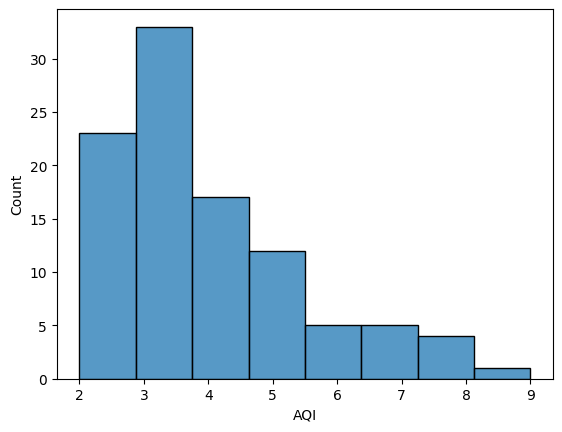

In [52]:
start_time = datetime.datetime.now()
streakdf, newdf, streakhist = mlbd.task3(base_df, model)
print(f'Average computation time (HH:MM:SS)', datetime.datetime.now() - start_time, '\n')

In [15]:
map = mlbd.plotMapStreak(newdf, 'histogram')
map

22/12/01 19:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/12/01 19:11:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB


In [16]:
map = mlbd.plotMapStreak(streakdf, 'streak')
map

In [17]:
map = mlbd.plotMapStreak(streakdf, 'continents')
map

In [18]:
!gcam "update code implementation"